#Import Liabraries

In [ ]:
!pip install catboost tensorflow keras_tuner

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score
import xgboost as xgb
from catboost import CatBoostClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt

#Data exploration

In [ ]:
df_raw = pd.read_csv("/content/booking.csv")
df_raw.head()

,Booking_ID,number of adults,number of children,number of weekend nights,number of week nights,type of meal,car parking space,room type,lead time,market segment type,repeated,P-C,P-not-C,average price,special requests,date of reservation,booking status
0,INN00001,1,1,2,5,Meal Plan 1,0,Room_Type 1,224,Offline,0,0,0,88.00,0,10/2/2015,Not_Canceled
1,INN00002,1,0,1,3,Not Selected,0,Room_Type 1,5,Online,0,0,0,106.68,1,11/6/2018,Not_Canceled
2,INN00003,2,1,1,3,Meal Plan 1,0,Room_Type 1,1,Online,0,0,0,50.00,0,2/28/2018,Canceled
3,INN00004,1,0,0,2,Meal Plan 1,0,Room_Type 1,211,Online,0,0,0,100.00,1,5/20/2017,Canceled
4,INN00005,1,0,1,2,Not Selected,0,Room_Type 1,48,Online,0,0,0,77.00,0,4/11/2018,Canceled


In [ ]:
df_raw.dtypes

,0
Booking_ID,object
number of adults,int64
number of children,int64
number of weekend nights,int64
number of week nights,int64
type of meal,object
car parking space,int64
room type,object
lead time,int64
market segment type,object


#Data preparation

##Data cleaning

In [ ]:
def extract_day(date_str):
  if '-' in date_str:
    return int(date_str.split('-')[2])
  return int(date_str.split('/')[1])

def extract_month(date_str):
  if '-' in date_str:
    return int(date_str.split('-')[1])
  return int(date_str.split('/')[0])

def extract_year(date_str):
  if '-' in date_str:
    return int(date_str.split('-')[0])
  return int(date_str.split('/')[2])

In [ ]:
df_raw['day'] = df_raw['date of reservation'].apply(extract_day)
df_raw['month'] = df_raw['date of reservation'].apply(extract_month)
df_raw['year'] = df_raw['date of reservation'].apply(extract_year)

df_raw = df_raw[(df_raw['day'] != 29) | (df_raw['month'] != 2)]
df_raw['date'] = pd.to_datetime(df_raw[['year', 'month', 'day']])

## data visualization

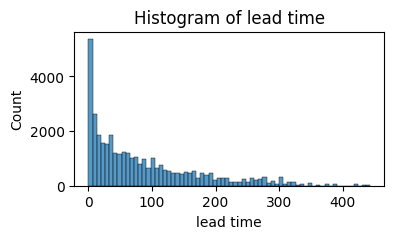

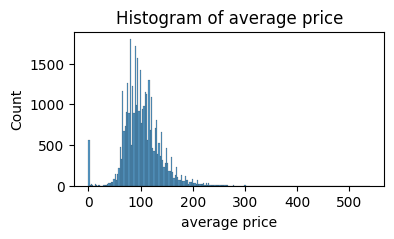

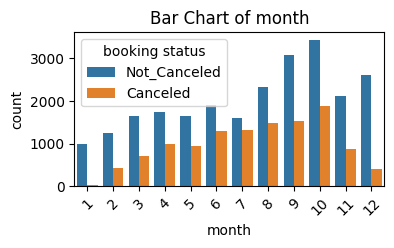

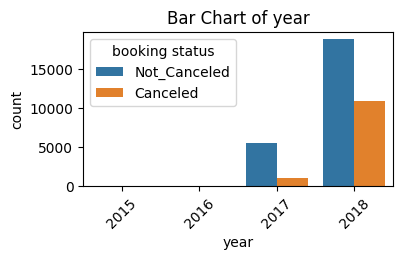

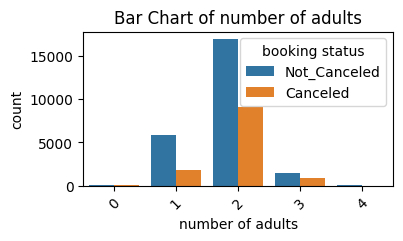

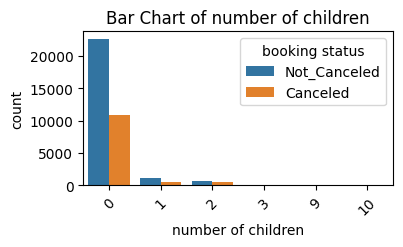

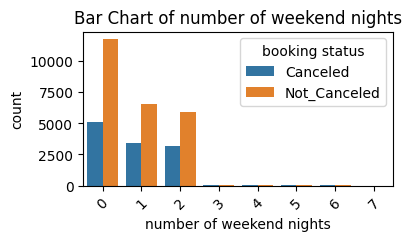

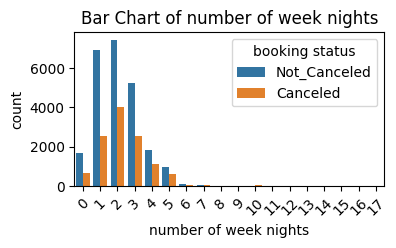

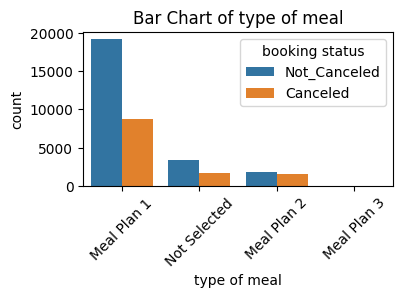

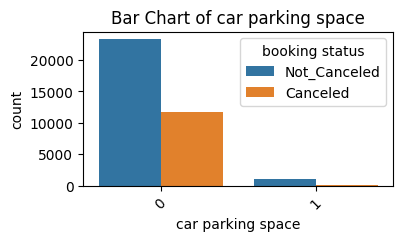

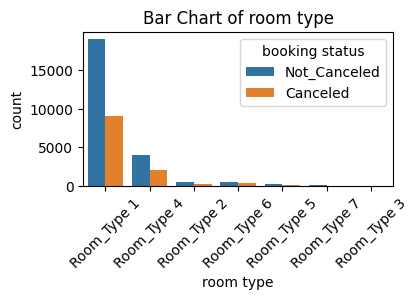

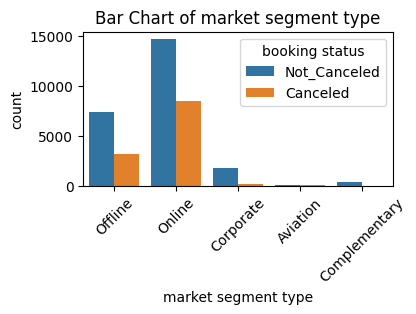

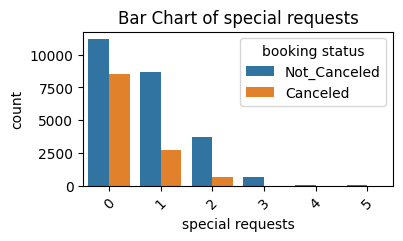

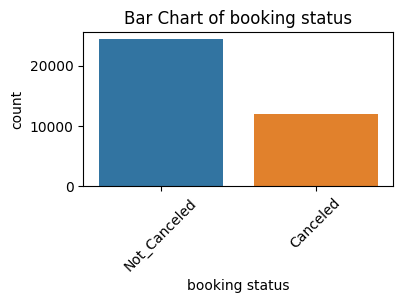

In [ ]:
numerical_cols = ['lead time', 'average price']
categorical_cols = ['month', 'year', 'number of adults', 'number of children', 'number of weekend nights', 'number of week nights', 'type of meal', 'car parking space', 'room type', 'market segment type', 'special requests', 'booking status']

for col in numerical_cols:
    plt.figure(figsize=(4, 2))
    sns.histplot(df_raw[col], kde=False)
    plt.title(f'Histogram of {col}')
    plt.show()

for col in categorical_cols:
    plt.figure(figsize=(4, 2))
    sns.countplot(x=df_raw[col], hue=df_raw['booking status'])
    plt.title(f'Bar Chart of {col}')
    plt.xticks(rotation=45)
    plt.show()

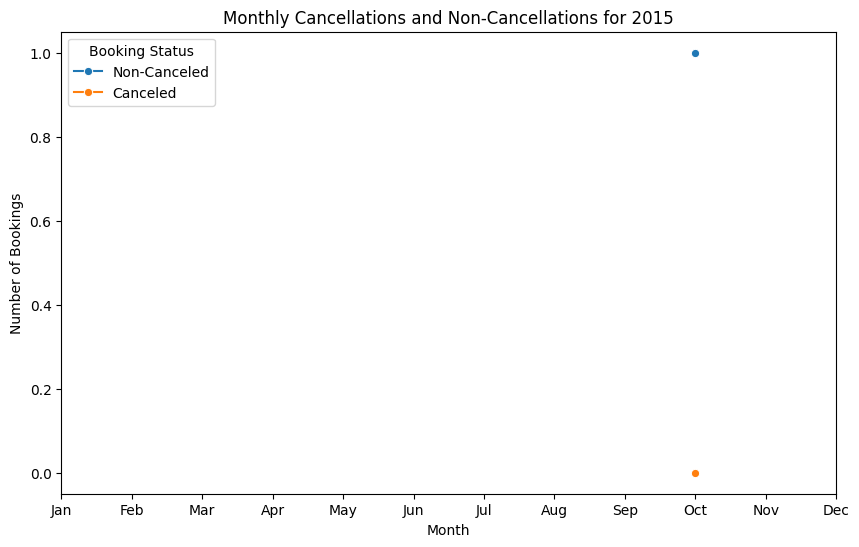

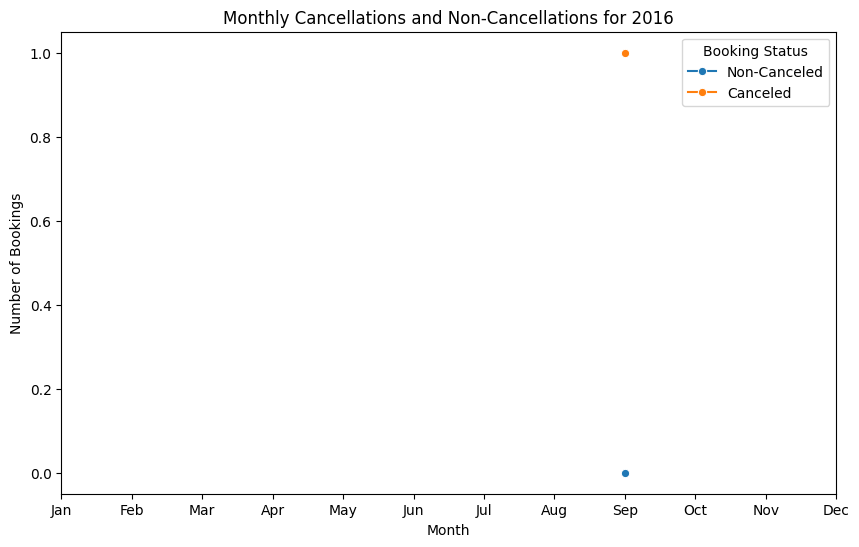

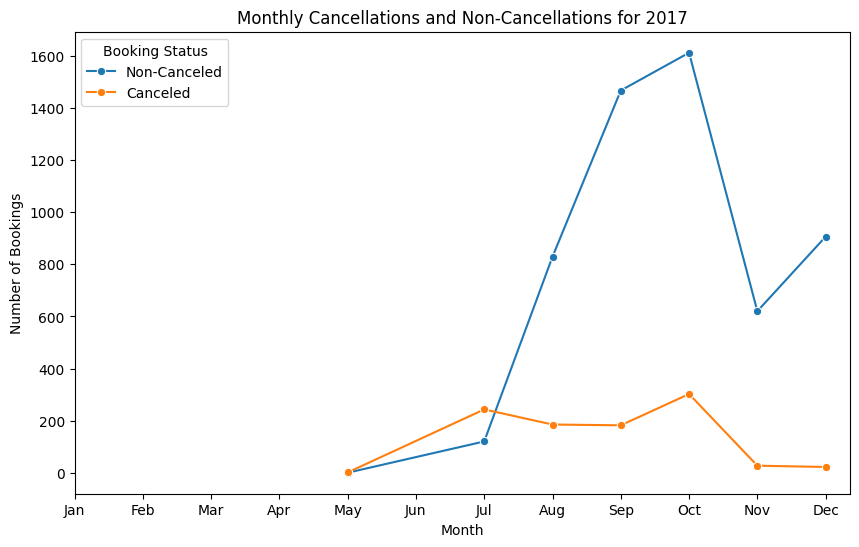

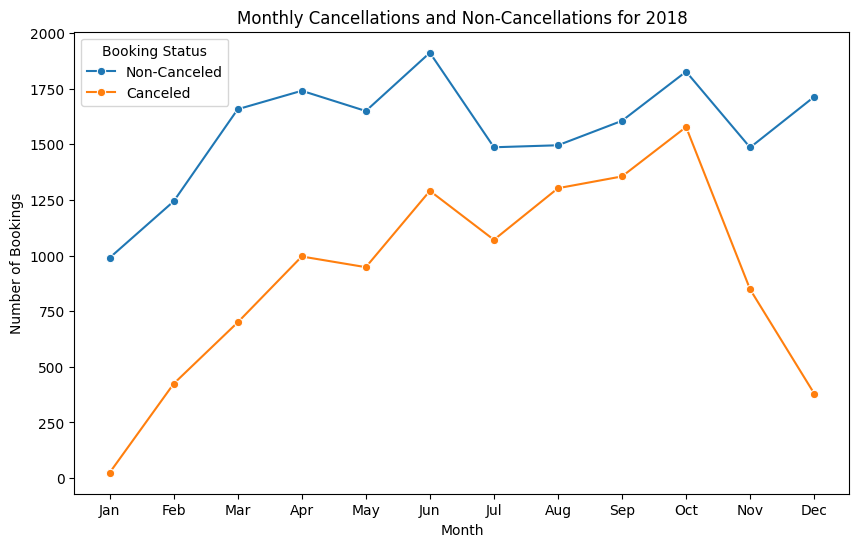

In [ ]:
monthly_cancellations = df_raw.groupby(['year', 'month', 'booking status']).size().unstack(fill_value=0).sort_index(level=['year', 'month'])

unique_years = sorted(df_raw['year'].unique())
for year in unique_years:
    plt.figure(figsize=(10, 6))

    yearly_data = monthly_cancellations.loc[year]

    sns.lineplot(x=yearly_data.index, y=yearly_data['Not_Canceled'], label='Non-Canceled', marker="o")

    sns.lineplot(x=yearly_data.index, y=yearly_data['Canceled'], label='Canceled', marker="o")

    plt.title(f'Monthly Cancellations and Non-Cancellations for {year}')
    plt.xlabel('Month')
    plt.ylabel('Number of Bookings')
    plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.legend(title='Booking Status')
    plt.show()

## Data preprocessing

In [ ]:
def extract_day_sin(row):
    day, year, month = row['day'], row['year'], row['month']
    if month == 2:
        return np.sin(2 * np.pi * day / 29) if year % 4 == 0  else np.sin(2 * np.pi * day / 28)
    elif month in [4, 6, 9, 11]:
        return np.sin(2 * np.pi * day / 30)
    else:
        return np.sin(2 * np.pi * day / 31)

def extract_day_cos(row):
    day, year, month = row['day'], row['year'], row['month']
    if month == 2:
        return np.cos(2 * np.pi * day / 29) if year % 4 == 0 else np.cos(2 * np.pi * day / 28)
    elif month in [4, 6, 9, 11]:
        return np.cos(2 * np.pi * day / 30)
    else:
        return np.cos(2 * np.pi * day / 31)

In [ ]:
df_raw['day_of_week'] = df_raw['date'].dt.dayofweek

df_raw['month_sin'] = np.sin(2 * np.pi * df_raw['month'].astype('int') / 12)
df_raw['month_cos'] = np.cos(2 * np.pi * df_raw['month'].astype('int') / 12)
df_raw['day_of_week_sin'] = np.sin(2 * np.pi * df_raw['day_of_week'].astype('int') / 7)
df_raw['day_of_week_cos'] = np.cos(2 * np.pi * df_raw['day_of_week'].astype('int') / 7)
df_raw['day_sin'] = df_raw.apply(extract_day_sin, axis=1)
df_raw['day_cos'] = df_raw.apply(extract_day_cos, axis=1)

df_pre_dummies = df_raw.drop(['Booking_ID', 'booking status', 'date of reservation', 'month', 'day', 'day_of_week', 'date'], axis=1)
X = pd.get_dummies(df_pre_dummies)
y = df_raw['booking status'].apply(lambda x: 1 if x == "Canceled" else 0)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

#Logistic Regression

In [ ]:
param_grid_log_reg = {'logisticregression__C': np.logspace(0.001, 100)}
pipeline_log_reg = make_pipeline(StandardScaler(), LogisticRegression())
grid_search_log_reg = GridSearchCV(pipeline_log_reg, param_grid=param_grid_log_reg, scoring='roc_auc')
grid_search_log_reg.fit(X_train, y_train)
print(f"ROC AUC score:{grid_search_log_reg.score(X_test, y_test)}")

ROC AUC score:0.8666628864863009


In [ ]:
grid_search_log_reg.best_params_

{'logisticregression__C': 1.0023052380778996}

#XGBoost

In [ ]:
param_grid_xgb = {'learning_rate': np.linspace(0.01, 0.15, 10), 'max_depth': range(5, 12), 'n_estimators': range(100, 210, 10)}
grid_search_xgb = GridSearchCV(xgb.XGBClassifier(), param_grid=param_grid_xgb, scoring='roc_auc')
grid_search_xgb.fit(X_train, y_train)
grid_search_xgb.score(X_test, y_test)
print(f"ROC AUC score:{grid_search_xgb.score(X_test, y_test)}")

ROC AUC score:0.959396763549333


In [ ]:
grid_search_xgb.best_params_

{'learning_rate': 0.10333333333333332, 'max_depth': 11, 'n_estimators': 180}

In [ ]:
best_xgb_model = grid_search_xgb.best_estimator_
best_xgb_model.save_model("best_xgb_model.json")

#CatBoost

## CatBoost Data preprocessing

In [ ]:
X_train_cb, X_test_cb, y_train_cb, y_test_cb = train_test_split(df_pre_dummies, y, random_state=0)

In [ ]:
X_train_cb.dtypes

,0
number of adults,int64
number of children,int64
number of weekend nights,int64
number of week nights,int64
type of meal,object
car parking space,int64
room type,object
lead time,int64
market segment type,object
repeated,int64


## Model training and evaluation

In [ ]:
param_grid_catboost = {'n_estimators': range(190, 211, 10), 'learning_rate': np.linspace(0.16, 0.2, 5), 'max_depth': range(9, 12)}
grid_search_catboost = GridSearchCV(CatBoostClassifier(verbose=0), param_grid=param_grid_catboost, scoring='roc_auc')
grid_search_catboost.fit(X_train_cb, y_train_cb, cat_features=[4, 6, 8])
print(f"ROC AUC score:{grid_search_catboost.score(X_test_cb, y_test_cb)}")

ROC AUC score:0.955442073110339


In [ ]:
grid_search_catboost.best_params_

{'learning_rate': 0.17, 'max_depth': 9, 'n_estimators': 190}

#Feedforward neural network

##Model creation

In [ ]:
def model_builder(hp):
  hp_units = hp.Int('units', min_value=32, max_value=128, step=32)
  hp_dropout_rate = hp.Choice('dropout_rate', values=[0.3, 0.5, 0.7])
  hp_learning_rate = hp.Choice('learning_rate', values=[0.1, 0.01, 0.001, 0.0001])

  model = Sequential()
  model.add(Dense(hp_units, input_dim=X_train.shape[1], activation='relu'))
  model.add(Dropout(hp_dropout_rate))
  model.add(Dense(hp_units // 2, activation='relu'))
  model.add(Dropout(hp_dropout_rate))
  model.add(Dense(hp_units // 2, activation='relu'))
  model.add(Dropout(hp_dropout_rate))
  model.add(Dense(hp_units // 4, activation='relu'))
  model.add(Dropout(hp_dropout_rate))
  model.add(Dense(1, activation='sigmoid'))

  model.compile(optimizer=Adam(learning_rate=hp_learning_rate), loss='binary_crossentropy', metrics=['auc'])

  return model

## Hyperparameter fine tuning

In [ ]:
tuner = kt.RandomSearch(model_builder, objective='val_auc')

In [ ]:
stop_early = EarlyStopping(monitor='val_loss', patience=5)
tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

Trial 10 Complete [00h 00m 29s]
val_auc: 0.5

Best val_auc So Far: 0.8621549606323242
Total elapsed time: 00h 07m 26s


In [ ]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"the best number of initial units: {best_hps.get('units')}")
print(f"the best learning rate: {best_hps.get('learning_rate')}")
print(f"the best dropout rate: {best_hps.get('dropout_rate')}")

the best number of initial units: 128
the best learning rate: 0.001
the best dropout rate: 0.3


In [ ]:
fnn_for_epochs = tuner.hypermodel.build(best_hps)
history = fnn_for_epochs.fit(X_train, y_train, epochs=50, validation_split=0.2)

In [ ]:
val_auc_per_epoch = history.history['val_auc']
best_epoch = val_auc_per_epoch.index(max(val_auc_per_epoch)) + 1

##Model training

In [ ]:
fnn = tuner.hypermodel.build(best_hps)
fnn.fit(X_train, y_train, epochs=best_epoch, validation_split=0.2)

##Model evaluation

In [ ]:
print(f"ROC AUC score:{fnn.evaluate(X_test, y_test)[1]}")

284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - auc: 0.8603 - loss: 0.4639
ROC AUC score:0.8702645301818848
